In [1]:

import numpy as np
import sys
import os
import pandas as pd
import glob as glob
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import itertools
from scipy import stats
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

In [2]:
cmap = 'husl'

In [3]:
def grouped_lineplot(df, x, y, hue, plot_marker=False, ymin=0, ymax=1, title=None, outfile=None, sig_lines=False, ci_estimator='mean'):
    sns.set_style("white")
    fig, ax = plt.subplots(figsize=(12.5,7.5))

    g = sns.lineplot(x=x, y=y, hue=hue, data=df,
                       palette=cmap, estimator=ci_estimator, ax=ax)   

    sns.despine(ax=ax, left=True)
    ax.set_title(title,fontsize=24)
    ax.set_ylabel(y,fontsize=24)
    ax.set_xlabel('Order',fontsize=24)
    ax.set_ylim(ymin, ymax)
    
    handles,labels = ax.get_legend_handles_labels()
    handles = [handles[1], handles[2], handles[3], handles[4]]
    labels = [labels[1].capitalize(), labels[2].capitalize(), labels[3].capitalize(), labels[4].capitalize()]
    
    pieman_cs = ['intact', 'paragraph', 'word', 'rest']
    color_order = [0, 2, 3, 5]
    #color_order = [0, 1, 2, 3]
    
    if plot_marker:
        for e, pc in enumerate(pieman_cs):
            pd_df = df[df['Condition']==pc]
            max_level = pd_df.groupby('Level').mean()[y]
            if type(plot_marker) is list:
                plt.plot(plot_marker[e], max_level[plot_marker[e]], marker='o', fillstyle='none', color=sns.color_palette(cmap)[color_order[e]], markersize=24)
            else:
                plt.plot(max_level.argmax(), max_level[max_level.argmax()], marker='o', fillstyle='none', color=sns.color_palette(cmap)[color_order[e]], markersize=24)

    if sig_lines:
        for e, pc in enumerate(pieman_cs):
            parsed_pd = df[(df['Condition']==pc)]
            p_array = np.zeros((1,11))
            for lev in np.arange(0, 11, 1):

                L = parsed_pd[parsed_pd['Level']==lev].groupby(['Condition', 'Reduction', 'Kernel', 'Width']).mean()[y].values
                not_L = parsed_pd[parsed_pd['Level']!=lev].groupby(['Condition', 'Reduction', 'Kernel', 'Width']).mean()[y].values
                t = stats.ttest_rel(L, not_L)      
                p_array[:, lev] = t.pvalue
                
            max_level = parsed_pd.groupby('Level').mean()[y].values
            
            bool_inds = p_array<=.05
            
            greater_ind = out_arr = np.logical_and(max_level>max_level.mean(), p_array<=.05)
            less_ind = out_arr = np.logical_and(max_level<max_level.mean(), p_array<=.05)
            plt.plot(np.arange(0,11,1)[greater_ind[0]], max_level[greater_ind[0]], marker='^', linestyle = 'None', color=sns.color_palette(cmap)[color_order[e]], markersize=14)
            plt.plot(np.arange(0,11,1)[less_ind[0]], max_level[less_ind[0]], marker='v', linestyle = 'None', color=sns.color_palette(cmap)[color_order[e]], markersize=14)
    
    l = ax.legend(handles,labels, loc='center left', bbox_to_anchor=(1.00, .65), ncol=1,fontsize=24)
    l._legend_box.align = "center"
    for line in l.get_lines():
        line.set_linewidth(4.0)
    ax.tick_params(labelsize=24)
    if not outfile:
        fig.show()
    else:
        fig.savefig(outfile, bbox_inches='tight')

In [4]:
def grouped_barplot(df, x, y, hue, ymin=0, ymax=1, title=None, outfile=None):
    fig, ax = plt.subplots(figsize=(12.5,7.5))
    g = sns.factorplot(x=x, y=y, hue=hue, data=df, kind="bar", estimator=np.mean, ci=95, n_boot=1000,
                       palette=cmap, ax=ax, order=['intact', 'paragraph', 'word', 'rest'])

    sns.despine(ax=ax, left=True)
    ax.set_title(title, fontsize=24)
    ax.set_ylabel(y, fontsize=24)
    ax.set_xlabel(x, fontsize=24)
    ax.set_ylim(ymin, ymax)

    l = ax.legend(loc='center', bbox_to_anchor=(1, .65), ncol=1, fontsize=24)
    l._legend_box.align = "center"
    l.set_title('Order',prop={'size':24})
    
    ax.tick_params(labelsize=24)
    if not outfile:
        fig.show()
    else:
        fig.savefig(outfile, bbox_inches='tight')

In [5]:
def average_param(params, conds):
    
    ave_data = pd.DataFrame()
    for e, con in enumerate(conds):

        for p in params:

            param_name = os.path.basename(os.path.splitext(p)[0])
            full_data = combine_param_df(p)

            p_df = full_data[full_data['Condition']==con]
            ave_rel_level = p_df.groupby(['Level', 'Condition']).mean()['Relative accuracy']
            ave_z_level = p_df.groupby(['Level', 'Condition']).mean()['Z accuracy']
            ave_norm_level = p_df.groupby(['Level', 'Condition']).mean()['Normalized accuracy']
            
            
            p_split = param_name.split('_')

            ave_rel_df = ave_rel_level.to_frame().reset_index()
            ave_z_df = ave_z_level.to_frame().reset_index()
            ave_norm_df = ave_norm_level.to_frame().reset_index()
            
            sum_data = pd.DataFrame({'Relative accuracy': ave_rel_df['Relative accuracy'],'Z accuracy': ave_z_df['Z accuracy'], 'Normalized accuracy': ave_norm_df['Normalized accuracy'],'Level': ave_rel_df['Level'], 'Condition': ave_rel_df['Condition'], 'Reduction': p_split[1], 'Kernel': p_split[-2], 'Width': int(p_split[-1])})

            if ave_data.empty:
                ave_data = sum_data
            else:
                ave_data = ave_data.append(sum_data)
                
    return ave_data
            

In [6]:
def comb_param(params, conds):
    comb_data = pd.DataFrame()


    for e, con in enumerate(pieman_conds):
        for p in params:
            param_name = os.path.basename(os.path.splitext(p)[0])
            full_data = combine_param_df(p)
            p_df = full_data[full_data['Condition']==con]
            p_split = param_name.split('_')
            temp_data = pd.DataFrame({'Relative accuracy': p_df['Relative accuracy'],
                                     'Z accuracy': p_df['Z accuracy'], 
                                     'Normalized accuracy': p_df['Normalized accuracy'],
                                     'Level': p_df['Level'], 
                                     'Condition': p_df['Condition'], 
                                     'Reduction': p_split[1], 'Kernel': p_split[-2], 'Width': int(p_split[-1])})
            if comb_data.empty:
                comb_data = temp_data
            else:
                comb_data = comb_data.append(temp_data)

    return comb_data

In [7]:
def combine_param_df(params):
    param_name = os.path.basename(os.path.splitext(params)[0])

    conds =glob.glob(os.path.join(params, '*.csv'))

    full_data = pd.DataFrame()
    for c in conds:

        cond_name = os.path.basename(os.path.splitext(c)[0])
        chance = 1/300      
        if cond_name == 'paragraph':
            chance = 1/272
        elif cond_name == 'rest':
            chance = 1/400

        data = pd.read_csv(c)
        data['condition'] = os.path.basename(os.path.splitext(c)[0])
        data['Relative accuracy'] = data['accuracy'] - chance
        data['Normalized accuracy']= data['accuracy'] - np.min(data.groupby('level')['accuracy'].mean())
        data['Normalized accuracy'] = data['Normalized accuracy'] / np.max(data.groupby('level')['Normalized accuracy'].mean())
        data['Z accuracy']= (data['accuracy'] - data['accuracy'].mean())/data['accuracy'].std()

        if full_data.empty:
            full_data = data
        else:
            full_data = full_data.append(data)

    full_data = full_data.rename(index=str, columns={"level": "Level", "accuracy": "Accuracy", "condition": "Condition"})

    return full_data

In [8]:
def max_level_bycolumn(ave_df, y='Relative accuracy'):
    
    pieman_cs = ['intact', 'paragraph', 'word', 'rest']
    
    max_lev = []
    for e, pc in enumerate(pieman_cs):
        pd_df = ave_df[ave_df['Condition']==pc]
        max_lev.append(pd_df.groupby('Level').mean()[y].argmax())
    
    return max_lev
        
    

In [9]:
figdir = '../figs'
if not os.path.isdir(figdir):
    os.mkdir(figdir)

In [10]:
#results_dir = os.path.join(os.getenv('HOME'), 'Desktop', 'timecorr_env', 'timecorr_paper', 'pieman', 'results')
results_dir = os.path.join('../../data/', 'results')

In [11]:
analysis_name = 'level_analysis_optimized_param_search'

In [12]:
data_dir = os.path.join(results_dir, analysis_name)

In [14]:
pieman_conds = ['intact', 'paragraph', 'word', 'rest']
Reduction_type = ['PCA', 'eigenvector']
Kernel_type = ['hat', 'gaussian', 'laplace']
Width_type = [5, 10, 20, 50]

## Compile across kernels

/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:29: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


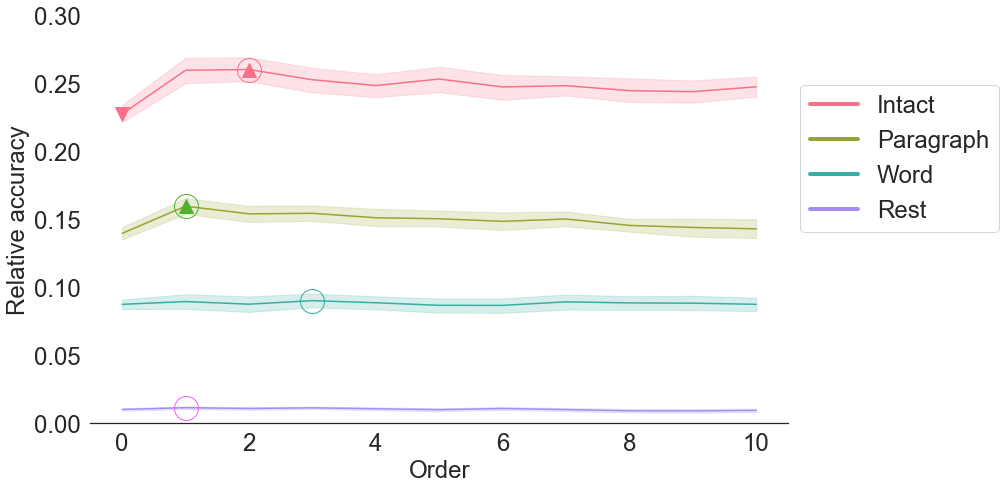

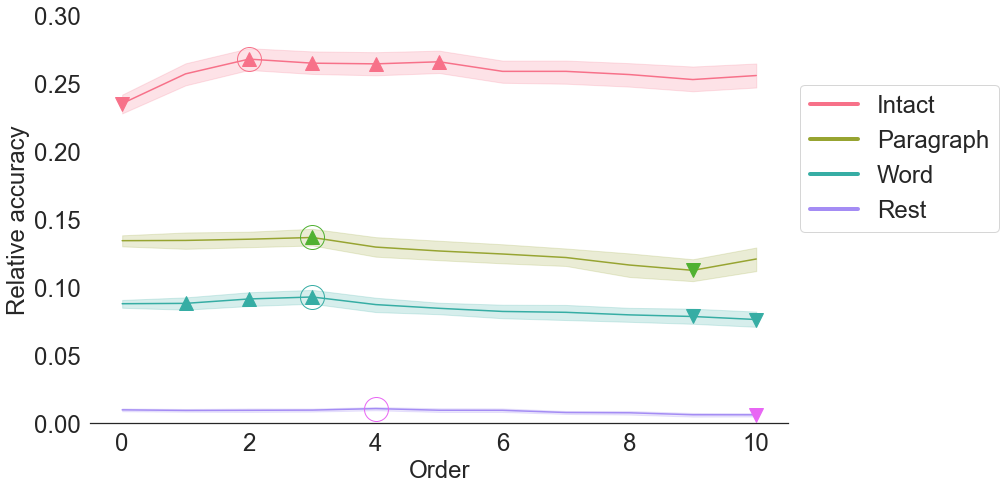

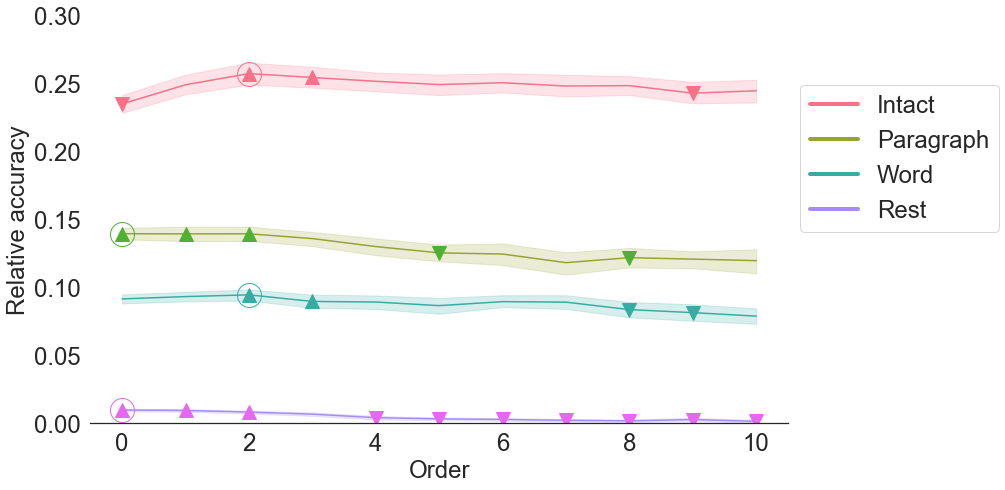

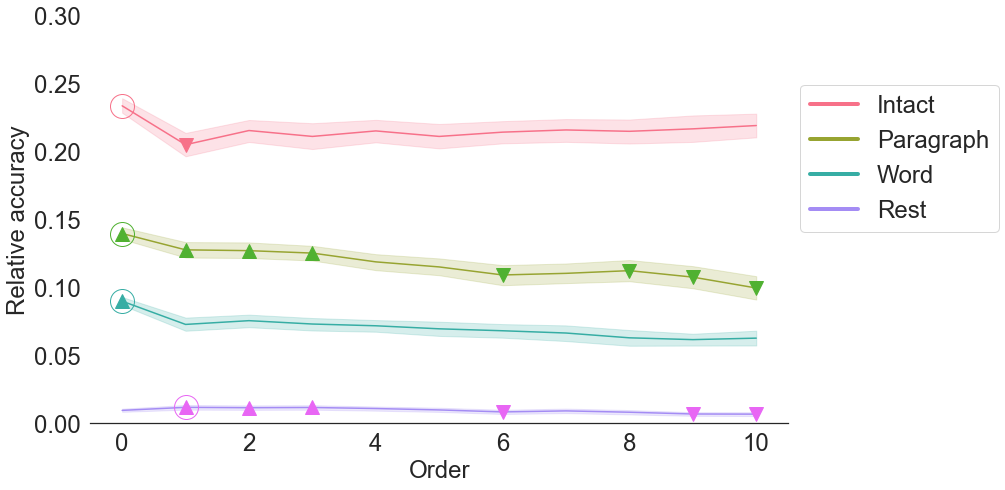

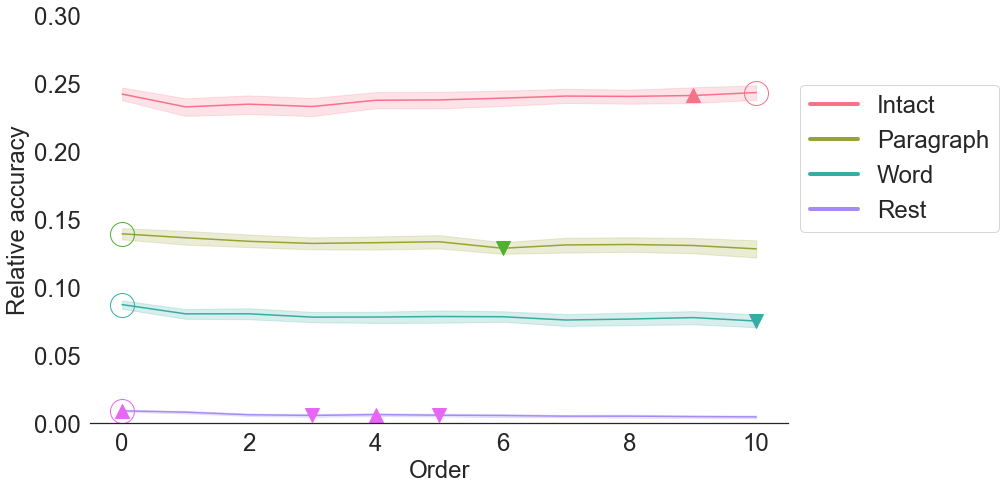

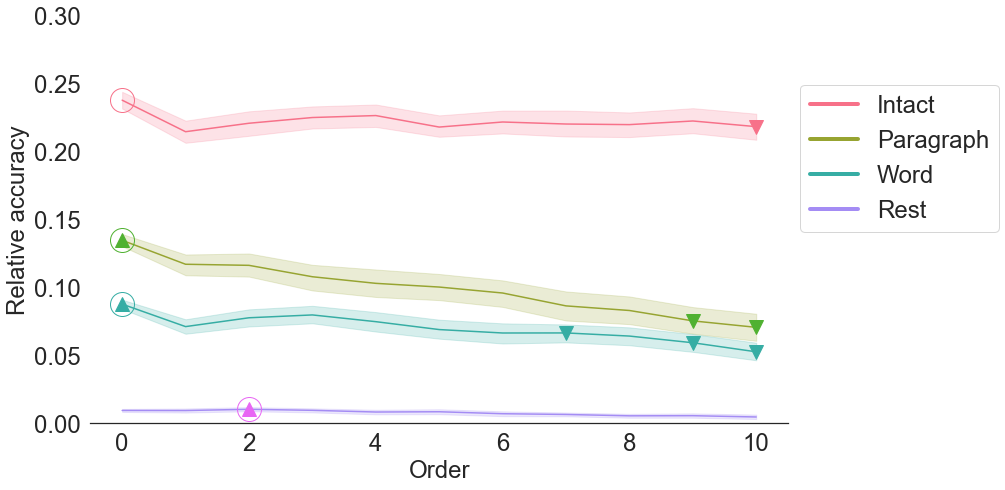

In [44]:
for k in Kernel_type:
    pieman_params =glob.glob(os.path.join(data_dir, '*_' + k + '_*'))
    
    pieman_conds = ['intact', 'paragraph', 'word', 'rest']

    comb_data = comb_param(pieman_params, pieman_conds)
    
    split_by = 'Reduction'

    for i in eval(split_by + '_type'):

        #outfile=None
        outfile = os.path.join(figdir, i + '_rel_ave_kernel_'+ k + '.pdf')
        
        grouped_lineplot(comb_data[comb_data[split_by]==i], 'Level', 'Relative accuracy','Condition', plot_marker=True, 
                         sig_lines=True, ymin=0, ymax=.3, title = '', outfile=outfile)

        plt.show()
        plt.close()
        
#         comb_data = comb_param(pieman_params, pieman_conds)

#         markers_y = max_level_bycolumn(comb_data[comb_data[split_by]==reduction_type], y='Relative accuracy')

#         outfile=None
#         #outfile = os.path.join(figdir, reduction_type + '_z_ave_'+ analysis_name + '.pdf')
#         grouped_lineplot(comb_data[comb_data[split_by]==reduction_type], 'Level', 'Z accuracy','Condition', plot_marker=markers_y, sig_lines=True, ymin=-1.5, ymax=1.5, title = '', outfile=outfile)
#         plt.show()
#         plt.close()

#         #outfile = os.path.join(figdir, reduction_type + '_rel_ave_'+ analysis_name + '.pdf')
#         grouped_lineplot(comb_data[comb_data[split_by]==reduction_type], 'Level', 'Relative accuracy','Condition', plot_marker=markers_y, sig_lines=True, ymin=0, ymax=.275, title = '', outfile=outfile)
#         plt.show()
#         plt.close()

#         #outfile = os.path.join(figdir, reduction_type + '_norm_ave_'+ analysis_name + '.pdf')
#         grouped_lineplot(comb_data[comb_data[split_by]==reduction_type], 'Level', 'Normalized accuracy','Condition', plot_marker=markers_y, sig_lines=True, ymin=0, ymax=1.05, title = '', outfile=outfile)
#         plt.show()
#         plt.close()


## Compile across width

/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:29: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


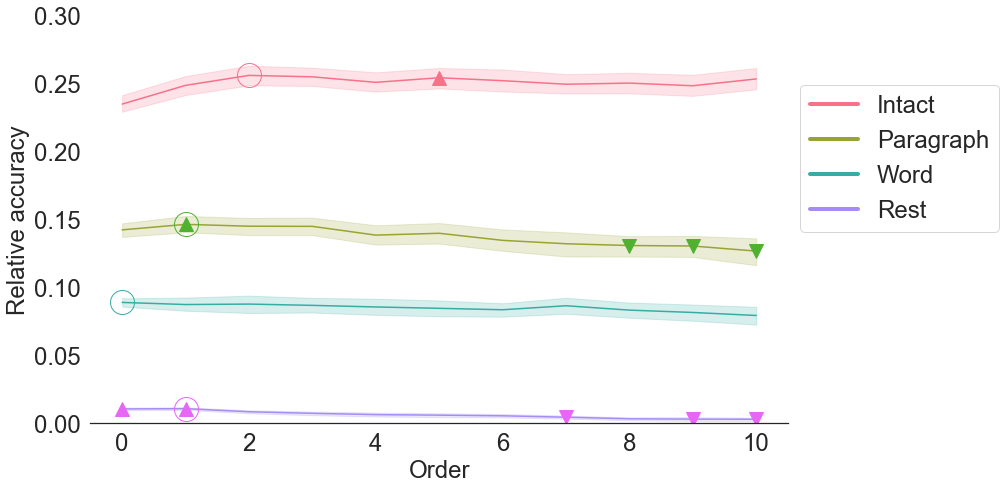

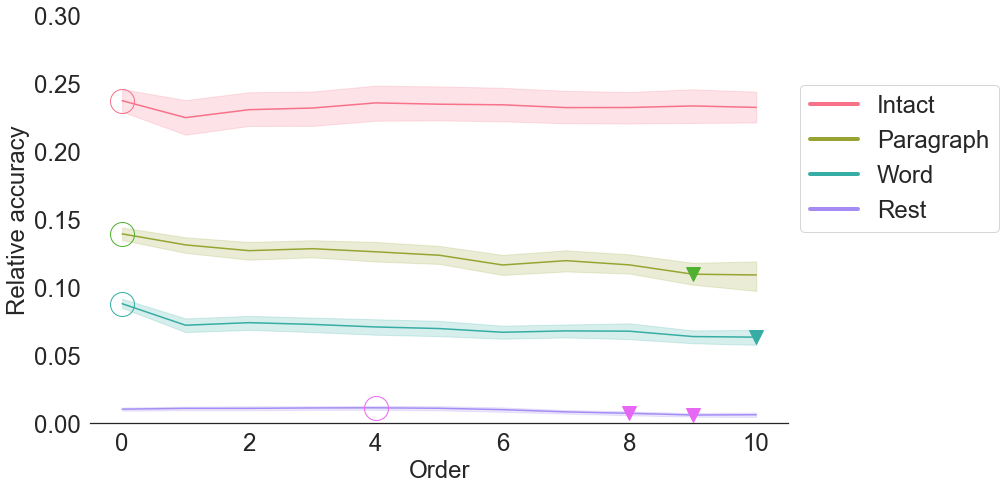

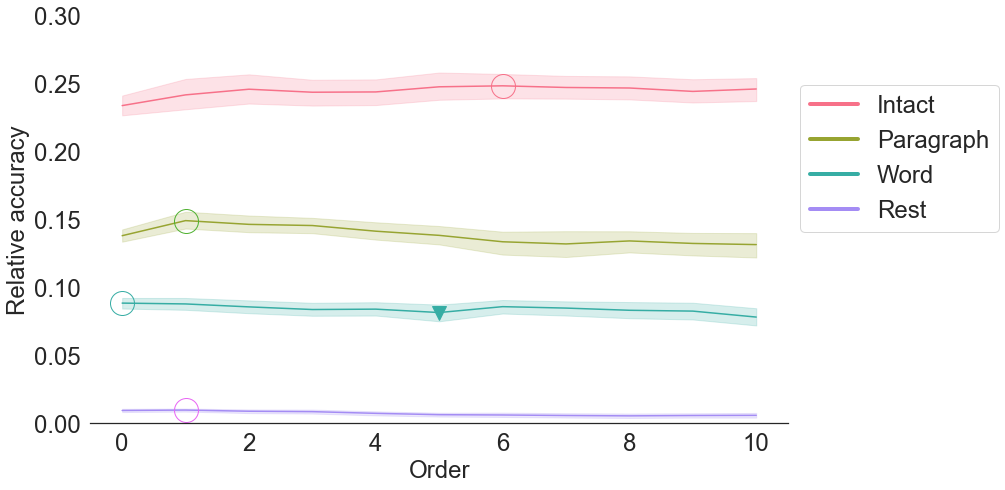

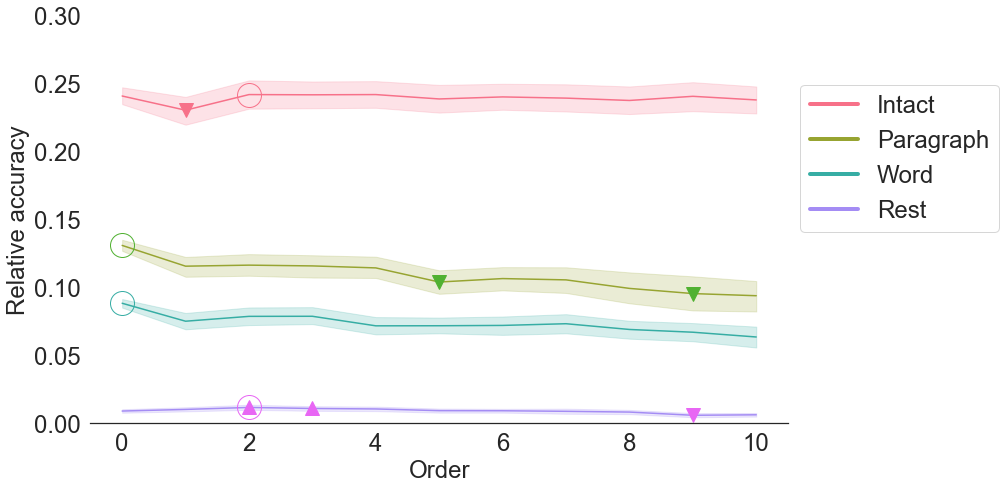

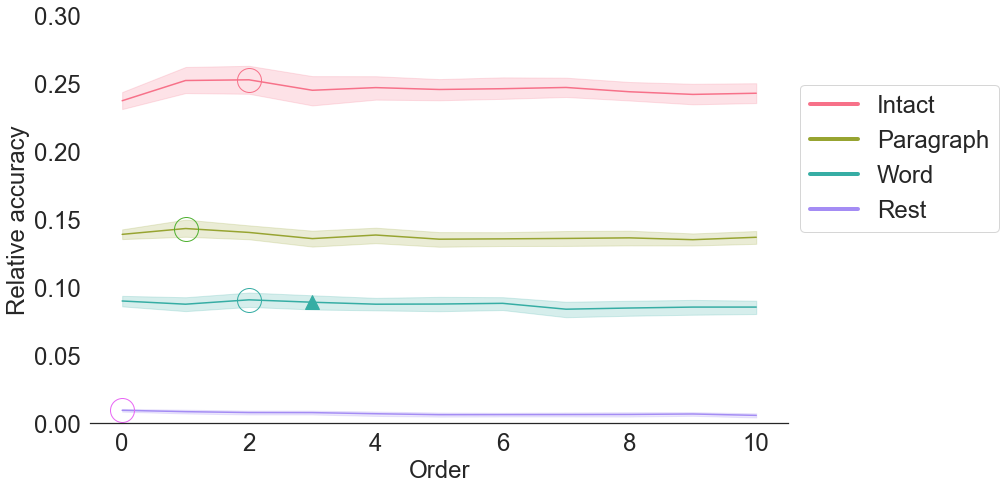

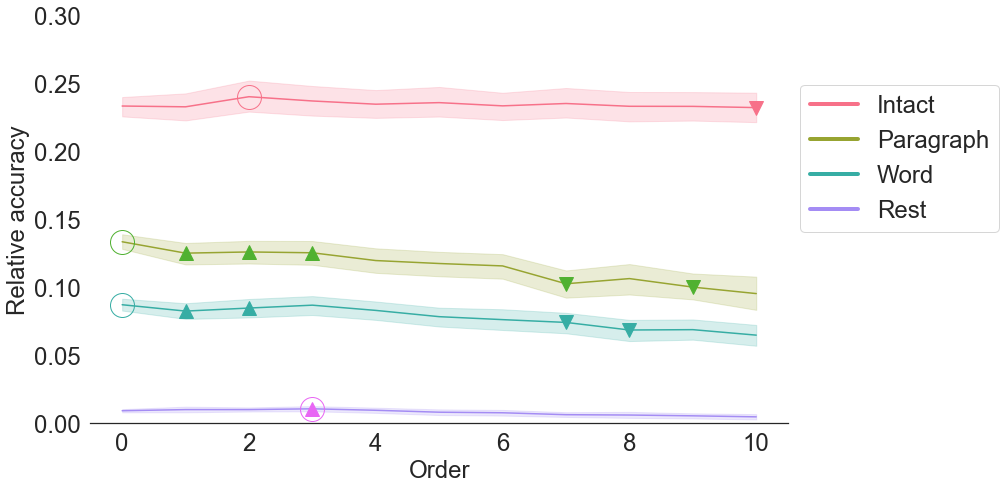

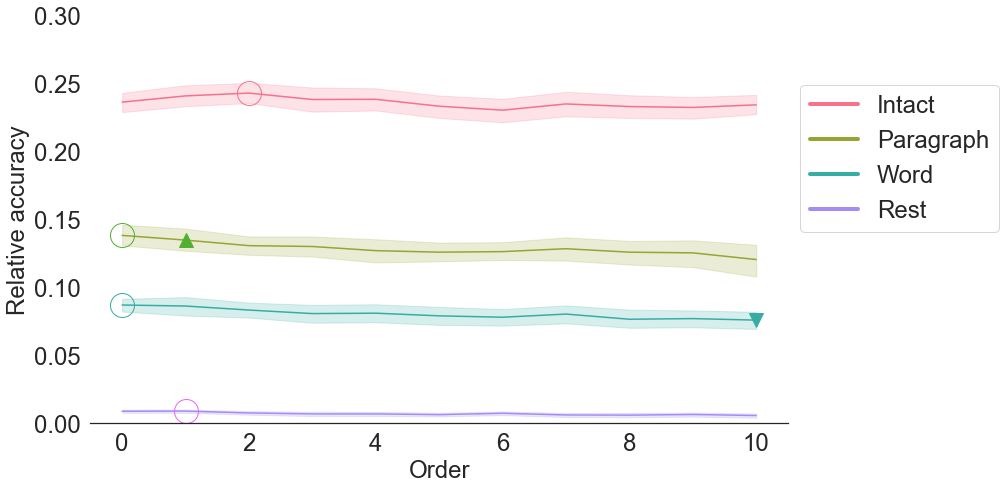

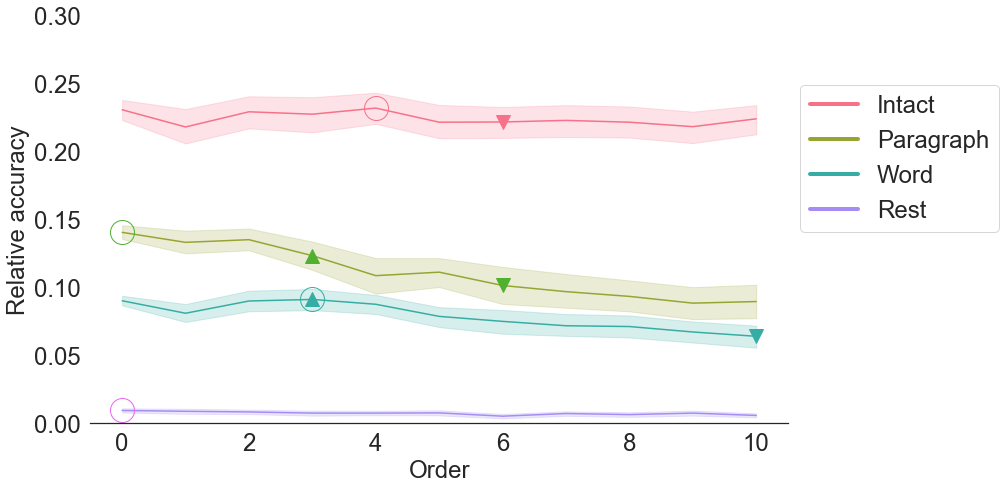

In [45]:
for w in Width_type:
    pieman_params =glob.glob(os.path.join(data_dir, '*_' + str(w)))
    
    pieman_conds = ['intact', 'paragraph', 'word', 'rest']

    comb_data = comb_param(pieman_params, pieman_conds)
    
    split_by = 'Reduction'

    for i in eval(split_by + '_type'):

        outfile = os.path.join(figdir, i + '_rel_ave_width_'+ str(w) + '.pdf')
        grouped_lineplot(comb_data[comb_data[split_by]==i], 'Level', 'Relative accuracy','Condition', plot_marker=True, 
                         sig_lines=True, ymin=0, ymax=.3, title = '', outfile=outfile)
        plt.show()
        plt.close()

In [36]:
pieman_params =glob.glob(os.path.join(data_dir, '*'))

In [37]:
pieman_params

['../../data/results/level_analysis_optimized_param_search/isfc_eigenvector_centrality_gaussian_10',
 '../../data/results/level_analysis_optimized_param_search/isfc_eigenvector_centrality_gaussian_20',
 '../../data/results/level_analysis_optimized_param_search/isfc_eigenvector_centrality_gaussian_5',
 '../../data/results/level_analysis_optimized_param_search/isfc_eigenvector_centrality_gaussian_50',
 '../../data/results/level_analysis_optimized_param_search/isfc_eigenvector_centrality_laplace_10',
 '../../data/results/level_analysis_optimized_param_search/isfc_eigenvector_centrality_laplace_20',
 '../../data/results/level_analysis_optimized_param_search/isfc_eigenvector_centrality_laplace_5',
 '../../data/results/level_analysis_optimized_param_search/isfc_eigenvector_centrality_laplace_50',
 '../../data/results/level_analysis_optimized_param_search/isfc_eigenvector_centrality_mexican_hat_10',
 '../../data/results/level_analysis_optimized_param_search/isfc_eigenvector_centrality_mexican